In [1]:
import os
import sys

import math
from datetime import timezone, datetime

import joblib
import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [2]:
# TimescaleDB用のユーティリティライブラリの設定
from timescaledb_util import TimeScaleDBUtil

_pg_config = {
        'user': os.environ['POSTGRES_USER'],
        'password': os.environ['POSTGRES_PASSWORD'],
        'host': os.environ['POSTGRES_HOST'],
        'port': os.environ['POSTGRES_PORT'],
        'database': os.environ['POSTGRES_DATABASE']
    }
    
_dbutil = TimeScaleDBUtil(user = _pg_config['user'], password = _pg_config['password'], host = _pg_config['host'], port = _pg_config['port'], database = _pg_config['database'])

In [3]:
def load_dollarbar(table_str, from_str, to_str, fee):
    _sql = f"SELECT * FROM \"{table_str}\" WHERE datetime >= '{from_str}' AND datetime < '{to_str}' ORDER BY dollar_cumsum ASC"
    df = _dbutil.read_sql_query(sql = _sql)
    df['fee'] = fee
    df = df[['datetime', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']]
    df.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']
    df = df.set_index("Datetime")    
    return df

# 学習区間のドルバーの読み込みと保存
df_train = load_dollarbar('ftx_btc-perp_dollarbar_10000000', '2021-07-01 00:00:00.000+00', '2022-01-01 00:00:00.000+00', 0.02/100)
df_train.to_pickle('df_train_ohlcv.pkl')

# バリデーション区間のドルバーの読み込みと保存
df_validation = load_dollarbar('ftx_btc-perp_dollarbar_10000000', '2022-01-01 00:00:00.000+00', '2023-01-01 00:00:00.000+00', 0.02/100)
df_validation.to_pickle('df_validation_ohlcv.pkl')
#mpf.plot(df_dollar, volume=False, figratio=(12, 6))

In [4]:
# Richmanbtc産のチュートリアルから取った関数
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

def calc_buysell(df, pips = 1, atr_mux = 0.5, atr_range=4):
    # ATRで指値距離を計算します
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=atr_range)
    limit_price_dist = df['ATR'] * atr_mux
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips
    
    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['Close'] - limit_price_dist
    df['sell_price'] = df['Close'] + limit_price_dist
    
    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['Low'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['High'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1
    
    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料
    
    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['Low'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['High'].shift(-1) / pips).round()).astype('float64')
    
    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['Close'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['Close'] - 1) + fee,
        0
    )
    
    return df

In [5]:
import optuna
import math

# ATRの指値幅を変数として、取引数とリターンの積を最大化するOptunaの最適化対象の関数
def target_function(x, y):
    df = pd.read_pickle('df_train_ohlcv.pkl')
    df = calc_buysell(df, pips = 1, atr_mux = x, atr_range=y)
    
    y_buy = df[df['buy_executed'] > 0]['y_buy'].sum()
    buy_count = len(df[df['buy_executed'] > 0])
    y_sell = df[df['sell_executed'] > 0]['y_sell'].sum()
    sell_count = len(df[df['sell_executed'] > 0])
    
    return y_buy + y_sell

# Optunaの最適化目的関数
def objective(trial):
    x = trial.suggest_uniform('x', 0.5, 2.0)
    y = trial.suggest_int('y', 14, 14)
    score = target_function(x, y)
    return score

# 最適化を実施
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=400)
#atr_mux = study.best_params['x']
#atr_range = study.best_params['y']
#optuna.visualization.plot_slice(study, params=["x"])

# 以前の学習結果を利用して最適化をスキップ
# 10_000_000ドルバー : Trial 74 finished with value: 16193.839450781088 and parameters: {'x': 1.4788760220633528}. Best is trial 74 with value: 16193.839450781088
# 5_000_000ドルバー : Trial 193 finished with value: 7080.370047388982 and parameters: {'x': 2.1472956042094262}. Best is trial 193 with value: 7080.370047388982.
atr_mux = 0.5
atr_range = 14

In [6]:
from sklearn.metrics import mean_squared_error

# パフォーマンスを表示する関数
def display_performance(df, subtitle):
    print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    df['buy_executed'].rolling(1000).mean().plot(label='Buy', ax=ax)
    df['sell_executed'].rolling(1000).mean().plot(label='Sell', ax=ax)
    plt.title(f'Execution probability ({subtitle})')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

    print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    df['buy_fet'].rolling(1000).mean().plot(label='Buy')
    df['sell_fet'].rolling(1000).mean().plot(label='Sell')
    plt.title(f'Average time until exit ({subtitle})')
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.show()

    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    df['buy_fet'].hist(alpha=0.3, label='Buy')
    df['sell_fet'].hist(alpha=0.3, label='Sell')
    plt.title(f'Time distribution until exit ({subtitle})')
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.show()

    print('毎時刻、この執行方法でトレードした場合の累積リターン')
    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    (df['buy_executed'] * df['y_buy']).cumsum().plot(label='Buy')
    (df['sell_executed'] * df['y_sell']).cumsum().plot(label='Sell')
    (df['buy_executed'] * df['y_buy'] + df['sell_executed'] * df['y_sell']).cumsum().plot(label='Buy+Sell')
    plt.title(f'Cumulative return ({subtitle})')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

    print(f'買いリターン {(df["buy_executed"] * df["y_buy"]).sum()*100:.2f}% 売りリターン {(df["sell_executed"] * df["y_sell"]).sum()*100:.2f}% 合計リターン {((df["buy_executed"] * df["y_buy"]).sum() + (df["sell_executed"] * df["y_sell"]).sum())*100:.2f}%')
    print(f'バーの数 {len(df)}本, 買い {len(df[(df["buy_executed"] > 0)])}回, 売り {len(df[df["sell_executed"] > 0])}回, 買った時のリターン平均 {df.loc[df["buy_executed"] > 0, "y_buy"].mean()*100:.03f} %, 売った時のリターン平均 {df.loc[df["sell_executed"] > 0, "y_sell"].mean()*100:.03f} %')
    print(f'リターンが0以上になる率 {(len(df[df["buy_executed"] * df["y_buy"] > 0]) + len(df[df["sell_executed"] * df["y_sell"] > 0])) / (len(df[(df["buy_executed"] > 0)]) + len(df[(df["sell_executed"] > 0)])) * 100} %')

    print('買いエントリーの統計量')
    print(df[df["buy_executed"] > 0]["y_buy"].describe())
    print('売りエントリーの統計量')
    print(df[df["sell_executed"] > 0]["y_sell"].describe())

def display_true_vs_pred(series_true, series_pred, subtitle):
    corr = np.corrcoef(series_pred, series_true)
    df = pd.DataFrame({'true': series_true, 'pred': series_pred})
    pred_std = df['pred'].std()
    pred_mean = df['pred'].mean()
    df_4std = df[(df['pred'] >= pred_mean - 4*pred_std) & (df['pred'] <= pred_mean + 4*pred_std)]
    pred_min = pred_mean - 4*pred_std
    
    pred_sections = []
    true_mean = []
    for i in range(9):
        _df = df[(df['pred'] >= pred_min + pred_std*i) & (df['pred'] >= pred_min + pred_std*(i+1))]
        pred_sections.append(pred_min + pred_std*i)
        true_mean.append(_df['true'].mean())
    
    plt.scatter(df_4std['pred'], df_4std['true'], s = 3)
    plt.step(pred_sections, true_mean, 'red', where='pre')
    plt.title(subtitle + f' (R={corr[0][1]:0.4f})')
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.show()


約定確率を可視化。時期によって約定確率が大きく変わると良くない。


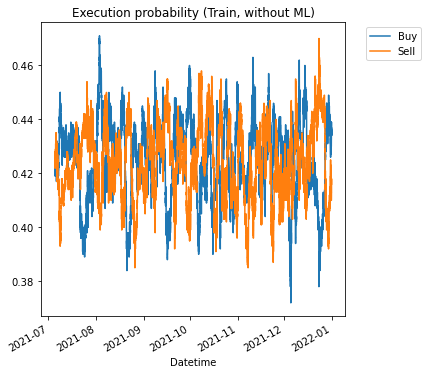

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


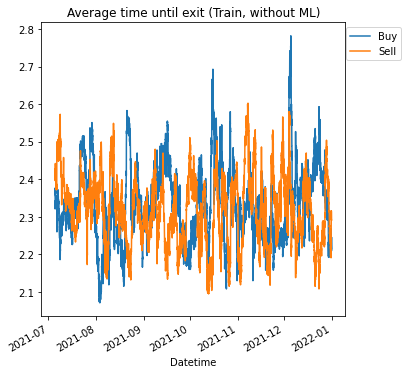

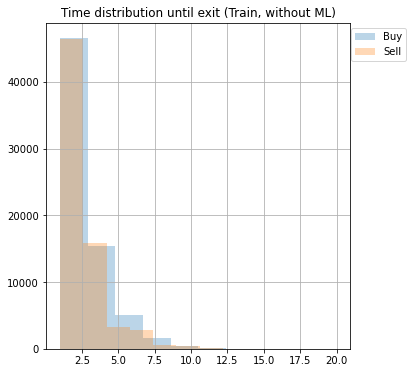

毎時刻、この執行方法でトレードした場合の累積リターン


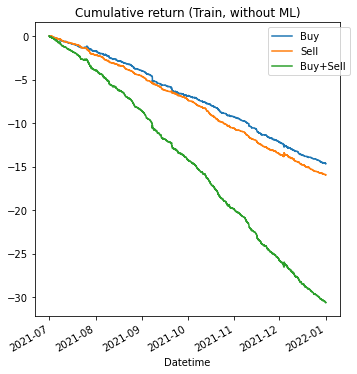

買いリターン -1466.88% 売りリターン -1595.88% 合計リターン -3062.75%
バーの数 69376本, 買い 29481回, 売り 29383回, 買った時のリターン平均 -0.050 %, 売った時のリターン平均 -0.054 %
リターンが0以上になる率 47.884955150856214 %
買いエントリーの統計量
count    29479.000000
mean        -0.000498
std          0.002801
min         -0.044984
25%         -0.001647
50%         -0.000099
75%          0.001024
max          0.035571
Name: y_buy, dtype: float64
売りエントリーの統計量
count    29383.000000
mean        -0.000543
std          0.002848
min         -0.045767
25%         -0.001715
50%         -0.000104
75%          0.001031
max          0.041816
Name: y_sell, dtype: float64


In [7]:
# Optunaの指値幅最適化結果に基づいて、学習区間でのパフォーマンス (MLフィルタ適応前) を表示
df_atr_optimized = pd.read_pickle('df_train_ohlcv.pkl')
df_atr_optimized = calc_buysell(df_atr_optimized, pips = 1, atr_mux = atr_mux)

# すべての行で売買するべきである、としておく
df_atr_optimized['y_pred_buy'] = 1.0
df_atr_optimized['y_pred_sell'] = 1.0

display_performance(df_atr_optimized, 'Train, without ML')

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


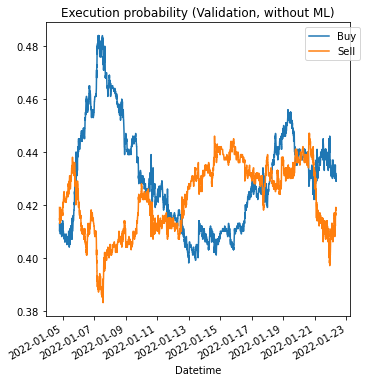

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


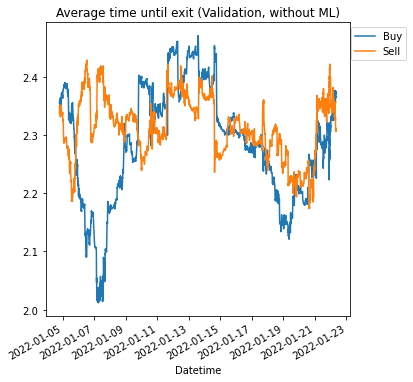

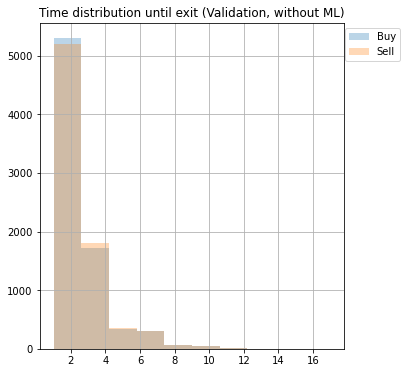

毎時刻、この執行方法でトレードした場合の累積リターン


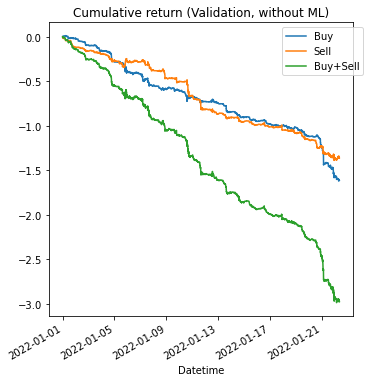

買いリターン -161.24% 売りリターン -136.00% 合計リターン -297.23%
バーの数 7776本, 買い 3353回, 売り 3265回, 買った時のリターン平均 -0.048 %, 売った時のリターン平均 -0.042 %
リターンが0以上になる率 49.048050770625565 %
買いエントリーの統計量
count    3353.000000
mean       -0.000481
std         0.002574
min        -0.016727
25%        -0.001669
50%        -0.000094
75%         0.000932
max         0.011587
Name: y_buy, dtype: float64
売りエントリーの統計量
count    3264.000000
mean       -0.000417
std         0.002647
min        -0.016254
25%        -0.001552
50%         0.000005
75%         0.001152
max         0.008299
Name: y_sell, dtype: float64


In [8]:
# Optunaの指値幅最適化結果に基づいて、バリデーション区間でのパフォーマンス (MLフィルタ適応前) を表示
df_atr_optimized = pd.read_pickle('df_validation_ohlcv.pkl')
df_atr_optimized = calc_buysell(df_atr_optimized, pips = 1, atr_mux = atr_mux)
display_performance(df_atr_optimized, 'Validation, without ML')

In [9]:
# Richmanbtcさんのチュートリアルから取った特徴量計算関数
def calc_features(df):
    open = df['Open']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['dollar_buy_volume'] + df['dollar_sell_volume']
    liquidation = df['dollar_liquidation_buy_volume'] + df['dollar_liquidation_sell_volume']
    
    hilo = (high + low) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)
    
    # ドルバー由来の特徴量を追加
    df['CLOSE_LOGDIFF'] = np.log1p(df['Close']).diff()
    df['BUY_DOLLAR_VOLUME_LOGDIFF'] = np.log1p(df['dollar_buy_volume']).diff()
    df['SELL_DOLLAR_VOLUME_LOGDIFF'] = np.log1p(df['dollar_sell_volume']).diff()
    df['BUY_DOLLAR_LIQUIDATION_LOGDIFF'] = np.log1p(df['dollar_liquidation_buy_volume']).diff()
    df['SELL_DOLLAR_LIQUIDATION_LOGDIFF'] = np.log1p(df['dollar_liquidation_sell_volume']).diff()
    
    df['BUY_RATIO'] = df['dollar_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['SELL_RATIO'] = df['dollar_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_BUY_RATIO'] = df['dollar_liquidation_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_SELL_RATIO'] = df['dollar_liquidation_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    
    df['BUY_RATIO_T-1'] = df['BUY_RATIO'].shift()
    df['SELL_RATIO_T-1'] = df['SELL_RATIO'].shift()
    df['LIQUIDATION_BUY_RATIO_T-1'] = df['LIQUIDATION_BUY_RATIO'].shift()
    df['LIQUIDATION_SELL_RATIO_T-1'] = df['LIQUIDATION_SELL_RATIO'].shift()

    df['BUY_RATIO_T-2'] = df['BUY_RATIO'].shift(2)
    df['SELL_RATIO_T-2'] = df['SELL_RATIO'].shift(2)
    df['LIQUIDATION_BUY_RATIO_T-2'] = df['LIQUIDATION_BUY_RATIO'].shift(2)
    df['LIQUIDATION_SELL_RATIO_T-2'] = df['LIQUIDATION_SELL_RATIO'].shift(2)
    
    df['BUY_RATIO_LOGDIFF'] = np.log1p(df['BUY_RATIO']*100).diff()
    df['SELL_RATIO_LOGDIFF'] = np.log1p(df['SELL_RATIO']*100).diff()
    df['LIQUIDATION_BUY_RATIO_LOGDIFF'] = np.log1p(df['LIQUIDATION_BUY_RATIO']*100).diff()
    df['LIQUIDATION_SELL_RATIO_LOGDIFF'] = np.log1p(df['LIQUIDATION_SELL_RATIO']*100).diff()
    
    df['BUY_RATIO_LOGDIFF_T-1'] = df['BUY_RATIO_LOGDIFF'].shift()
    df['SELL_RATIO_LOGDIFF_T-1'] = df['SELL_RATIO_LOGDIFF'].shift()
    df['LIQUIDATION_BUY_RATIO_LOGDIFF_T-1'] = df['LIQUIDATION_BUY_RATIO_LOGDIFF'].shift()
    df['LIQUIDATION_SELL_RATIO_LOGDIFF_T-1'] = df['LIQUIDATION_SELL_RATIO_LOGDIFF'].shift()

    df['BUY_RATIO_LOGDIFF_T-2'] = df['BUY_RATIO_LOGDIFF'].shift(2)
    df['SELL_RATIO_LOGDIFF_T-2'] = df['SELL_RATIO_LOGDIFF'].shift(2)
    df['LIQUIDATION_BUY_RATIO_LOGDIFF_T-2'] = df['LIQUIDATION_BUY_RATIO_LOGDIFF'].shift(2)
    df['LIQUIDATION_SELL_RATIO_LOGDIFF_T-2'] = df['LIQUIDATION_SELL_RATIO_LOGDIFF'].shift(2)
    
    df['TIME'] = df.index
    df['DELTA_TIME'] = df['TIME'].diff()
    df['DELTA_TIME'] = df['DELTA_TIME'].view(int) / 1_000_000_000 # 単位は秒
    df['DELTA_TIME_T-1'] = df['DELTA_TIME'].shift()
    df['DELTA_TIME_T-2'] = df['DELTA_TIME'].shift(2)
    
    return df.dropna()

In [10]:
# 学習に利用しない特徴量をコメントアウトする
features = sorted([
#    'ADX', 'ADXR', 'APO',
#    'AROON_aroondown', 'AROON_aroonup', 'AROONOSC',
#    'CCI',
#    'DX',
#    'MACD_macd', 'MACD_macdsignal', 'MACD_macdhist',
#    'MFI',
#    'MINUS_DI', 'MINUS_DM',
#    'MOM',
#    'PLUS_DI', 'PLUS_DM',
#    'RSI',
#    'STOCH_slowk', 'STOCH_slowd', 'STOCHF_fastk', 'STOCHRSI_fastd',
#    'ULTOSC',
#    'WILLR',
#    'ADOSC',
#    'NATR', # NATRはいつもfeature importanceが非常に高くなってしまう
#    'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDMODE', 'HT_TRENDLINE',
#    'BETA',
#    'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE',
#    'STDDEV',
#    'BBANDS_upperband', 'BBANDS_middleband', 'BBANDS_lowerband',
#    'DEMA', 'EMA', 'KAMA', 'MA',
#    'MIDPOINT',
#    'T3',
#    'TEMA', 'TRIMA', 'WMA',

    # richmanbtcさんのチュートリアルには存在しなかった特徴量
#    'CLOSE_LOGDIFF', # CLOSE_LOGDIFFはいつもfeature importanceが非常に高くなってしまう
#    'BUY_DOLLAR_VOLUME_LOGDIFF', 'SELL_DOLLAR_VOLUME_LOGDIFF', 'BUY_DOLLAR_LIQUIDATION_LOGDIFF', 'SELL_DOLLAR_LIQUIDATION_LOGDIFF',
    'BUY_RATIO', 'SELL_RATIO',
    'LIQUIDATION_BUY_RATIO', 'LIQUIDATION_SELL_RATIO',
    'BUY_RATIO_T-1', 'SELL_RATIO_T-1',
    'LIQUIDATION_BUY_RATIO_T-1', 'LIQUIDATION_SELL_RATIO_T-1',
    'BUY_RATIO_T-2', 'SELL_RATIO_T-2',
    'LIQUIDATION_BUY_RATIO_T-2', 'LIQUIDATION_SELL_RATIO_T-2',
#    'BUY_RATIO_LOGDIFF', 'SELL_RATIO_LOGDIFF',
#    'LIQUIDATION_BUY_RATIO_LOGDIFF', 'LIQUIDATION_SELL_RATIO_LOGDIFF',
#    'BUY_RATIO_LOGDIFF_T-1', 'SELL_RATIO_LOGDIFF_T-1',
#    'LIQUIDATION_BUY_RATIO_LOGDIFF_T-1', 'LIQUIDATION_SELL_RATIO_LOGDIFF_T-1',
#    'BUY_RATIO_LOGDIFF_T-2', 'SELL_RATIO_LOGDIFF_T-2',
#    'LIQUIDATION_BUY_RATIO_LOGDIFF_T-2', 'LIQUIDATION_SELL_RATIO_LOGDIFF_T-2',
    'DELTA_TIME', 'DELTA_TIME_T-1', 'DELTA_TIME_T-2'
])

print(features)

['BUY_RATIO', 'BUY_RATIO_T-1', 'BUY_RATIO_T-2', 'DELTA_TIME', 'DELTA_TIME_T-1', 'DELTA_TIME_T-2', 'LIQUIDATION_BUY_RATIO', 'LIQUIDATION_BUY_RATIO_T-1', 'LIQUIDATION_BUY_RATIO_T-2', 'LIQUIDATION_SELL_RATIO', 'LIQUIDATION_SELL_RATIO_T-1', 'LIQUIDATION_SELL_RATIO_T-2', 'SELL_RATIO', 'SELL_RATIO_T-1', 'SELL_RATIO_T-2']


In [11]:
import optuna.integration.lightgbm as lgb_tuner
import lightgbm as lgb

# 固定するパラメータ
params = {'objective':'regression',
          'metric': 'rmse',
          'verbosity':-1,
          'boosting_type': 'gbdt',
          'n_jobs': -1}

optuna.logging.set_verbosity(optuna.logging.ERROR)

# トレーニングデータに売買アクションと特徴量を追加
df_train = pd.read_pickle('df_train_ohlcv.pkl')
df_train = df_train.copy()
df_train = calc_buysell(df_train, pips = 1, atr_mux = atr_mux)
df_train = calc_features(df_train)
df_train.to_pickle('df_train_ohlcv_features_buysell.pkl')

# バリデーションデータに売買アクションと特徴量を追加
df_validation = pd.read_pickle('df_validation_ohlcv.pkl')
df_validation = df_validation.copy()
df_validation = calc_buysell(df_validation, pips = 1, atr_mux = atr_mux)
df_validation = calc_features(df_validation)
df_validation.to_pickle('df_validation_ohlcv_features_buysell.pkl')

# トレーニングデータからy_buyとy_sellが両方0の行数を削る (1.0だとすべて含めて、0だと一つも含まない)
#fraction = 1.0
#df_train_somey = df_dollar[(df_dollar['y_buy'] > 0) | (df_dollar['y_buy'] < 0) | (df_dollar['y_sell'] > 0) | (df_dollar['y_sell'] < 0)]
#df_train_zeroy = df_dollar[~((df_dollar['y_buy'] > 0) | (df_dollar['y_buy'] < 0) | (df_dollar['y_sell'] > 0) | (df_dollar['y_sell'] < 0))]
#df_train_zeroy_sampled = df_train_zeroy.sample(frac=1)
#df_train = pd.concat([df_train_somey, df_train_zeroy_sampled])

/tmp/ipykernel_1905584/917263284.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BUY_RATIO_LOGDIFF_T-2'] = df['BUY_RATIO_LOGDIFF'].shift(2)
/tmp/ipykernel_1905584/917263284.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['SELL_RATIO_LOGDIFF_T-2'] = df['SELL_RATIO_LOGDIFF'].shift(2)
/tmp/ipykernel_1905584/917263284.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

In [12]:
# トレーニングデータを抽出
lgb_buy_train = lgb_tuner.Dataset(df_train[features], df_train['y_buy'], free_raw_data=False)
lgb_sell_train = lgb_tuner.Dataset(df_train[features], df_train['y_sell'], free_raw_data=False)

# 買いモデル用バリデーションデータを抽出
lgb_buy_validation = lgb_tuner.Dataset(df_validation[features], df_validation['y_buy'], reference=lgb_buy_train, free_raw_data=False)
lgb_sell_validation = lgb_tuner.Dataset(df_validation[features], df_validation['y_sell'], reference=lgb_sell_train, free_raw_data=False)

# Optunaでのパラメータ探索
study_buy = optuna.create_study()
model_buy = lgb_tuner.train(params, lgb_buy_train, valid_sets=[lgb_buy_validation],
                      early_stopping_rounds = 100,
                      verbose_eval=0,
                      study = study_buy)

study_sell = optuna.create_study()
model_sell = lgb_tuner.train(params, lgb_sell_train, valid_sets=[lgb_sell_validation],
                      early_stopping_rounds = 100,
                      verbose_eval=0,
                      study = study_sell)

# トレーニングしたモデルを保存
joblib.dump(model_buy, 'model_y_buy.xz', compress=True) 
joblib.dump(model_sell, 'model_y_sell.xz', compress=True)

print(f'Best buy params: {model_buy.params}')
print(f'Best sell params: {model_sell.params}')

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.001703:  14%|#4        | 1/7 [00:00<00:01,  3.21it/s]/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be remove

Best buy params: {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'n_jobs': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.4730049106649542, 'bagging_freq': 7, 'min_child_samples': 100, 'num_iterations': 1000, 'early_stopping_round': 100}
Best sell params: {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'n_jobs': -1, 'feature_pre_filter': False, 'lambda_l1': 1.2766931260414606e-07, 'lambda_l2': 0.07411356989324583, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}


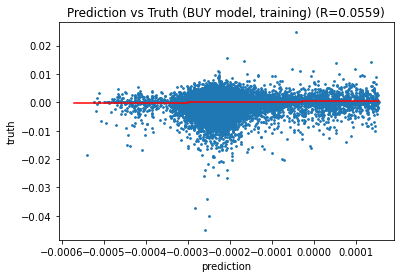

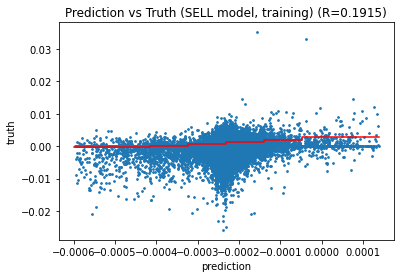

In [13]:
# 学習区間での真値と予測値を散布図で比較する
df_train['y_pred_buy'] = model_buy.predict(df_train[features], num_iteration=model_buy.best_iteration)
df_train['y_pred_sell'] = model_sell.predict(df_train[features], num_iteration=model_buy.best_iteration)

display_true_vs_pred(df_train['y_buy'], df_train['y_pred_buy'], 'Prediction vs Truth (BUY model, training)')
display_true_vs_pred(df_train['y_sell'], df_train['y_pred_sell'], 'Prediction vs Truth (SELL model, training)')

/tmp/ipykernel_1905584/917263284.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BUY_RATIO_LOGDIFF_T-2'] = df['BUY_RATIO_LOGDIFF'].shift(2)
/tmp/ipykernel_1905584/917263284.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['SELL_RATIO_LOGDIFF_T-2'] = df['SELL_RATIO_LOGDIFF'].shift(2)
/tmp/ipykernel_1905584/917263284.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


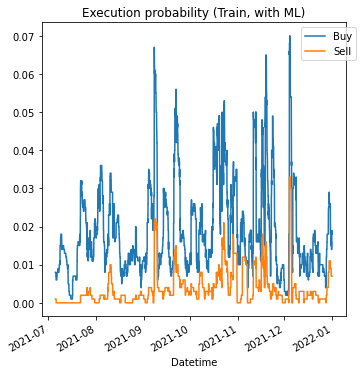

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


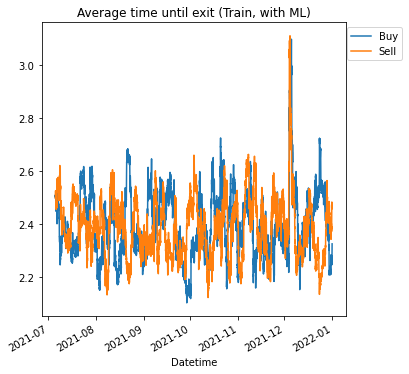

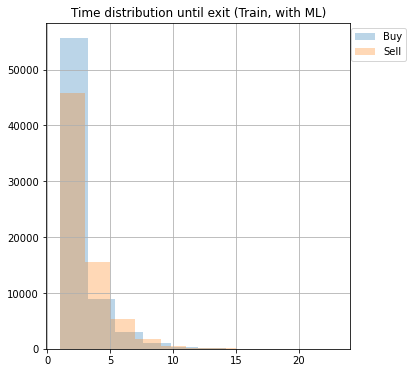

毎時刻、この執行方法でトレードした場合の累積リターン


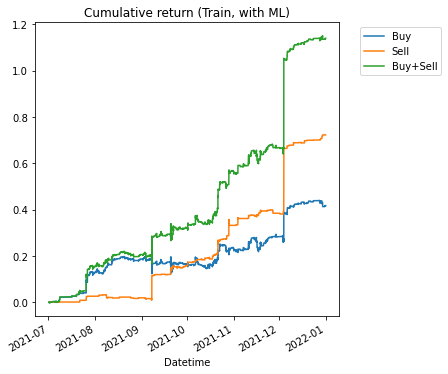

買いリターン 41.74% 売りリターン 72.28% 合計リターン 114.02%
バーの数 69285本, 買い 1463回, 売り 314回, 買った時のリターン平均 0.029 %, 売った時のリターン平均 0.230 %
リターンが0以上になる率 58.91952729319077 %
買いエントリーの統計量
count    1463.000000
mean        0.000285
std         0.003936
min        -0.041421
25%        -0.001216
50%         0.000301
75%         0.001834
max         0.029566
Name: y_buy, dtype: float64
売りエントリーの統計量
count    314.000000
mean       0.002302
std        0.005231
min       -0.021791
25%       -0.000205
50%        0.001561
75%        0.003850
max        0.037344
Name: y_sell, dtype: float64


In [14]:
# 学習区間でMLフィルタ適応後のパフォーマンスを確認して、MLがきちんと動いていることを確認
df_train = pd.read_pickle('df_train_ohlcv.pkl')
df_train = calc_buysell(df_train, pips = 1, atr_mux = atr_mux, atr_range=atr_range)
df_train = calc_features(df_train)
df_train['y_pred_buy'] = model_buy.predict(df_train[features], num_iteration=model_buy.best_iteration)
df_train['y_pred_sell'] = model_sell.predict(df_train[features], num_iteration=model_sell.best_iteration)

# 予測が正でないフレームのbuy_executedとsell_executedをすべて0にしておく
df_train.loc[df_train['y_pred_buy'] <= 0, 'buy_executed'] = 0.0
df_train.loc[df_train['y_pred_sell'] <= 0, 'sell_executed'] = 0.0

# パフォーマンスの表示
display_performance(df_train, 'Train, with ML')

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


/tmp/ipykernel_1905584/917263284.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BUY_RATIO_LOGDIFF_T-2'] = df['BUY_RATIO_LOGDIFF'].shift(2)
/tmp/ipykernel_1905584/917263284.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['SELL_RATIO_LOGDIFF_T-2'] = df['SELL_RATIO_LOGDIFF'].shift(2)
/tmp/ipykernel_1905584/917263284.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

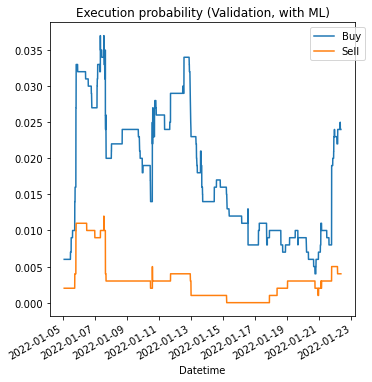

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


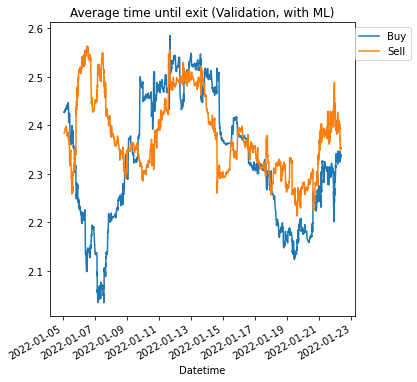

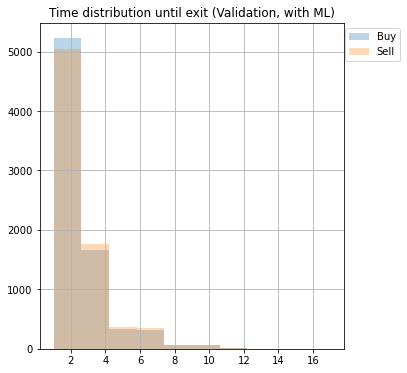

毎時刻、この執行方法でトレードした場合の累積リターン


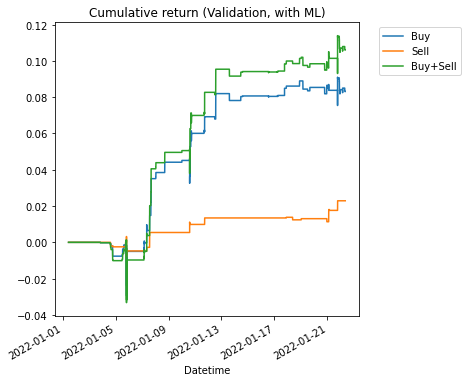

買いリターン 8.31% 売りリターン 2.29% 合計リターン 10.60%
バーの数 7685本, 買い 137回, 売り 26回, 買った時のリターン平均 0.061 %, 売った時のリターン平均 0.088 %
リターンが0以上になる率 60.122699386503065 %
買いエントリーの統計量
count    137.000000
mean       0.000607
std        0.003129
min       -0.010300
25%       -0.001226
50%        0.000553
75%        0.002410
max        0.008189
Name: y_buy, dtype: float64
売りエントリーの統計量
count    26.000000
mean      0.000881
std       0.002877
min      -0.006327
25%      -0.000960
50%       0.000631
75%       0.002744
max       0.006724
Name: y_sell, dtype: float64


In [15]:
# バリデーション区間でMLフィルタ適応後のパフォーマンスを確認する
df_validation = pd.read_pickle('df_validation_ohlcv.pkl')
df_validation = calc_buysell(df_validation, pips = 1, atr_mux = atr_mux, atr_range = atr_range)
df_validation = calc_features(df_validation)
df_validation.loc[:, 'y_pred_buy'] = model_buy.predict(df_validation[features], num_iteration=model_buy.best_iteration)
df_validation.loc[:, 'y_pred_sell'] = model_sell.predict(df_validation[features], num_iteration=model_sell.best_iteration)

# 予測が正でないフレームのbuy_executedをすべて0にしておく
df_validation.loc[df_validation['y_pred_buy'] <= 0, 'buy_executed'] = 0.0
df_validation.loc[df_validation['y_pred_sell'] <= 0, 'sell_executed'] = 0.0

# パフォーマンスの表示
display_performance(df_validation, 'Validation, with ML')

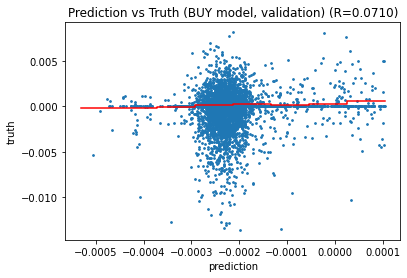

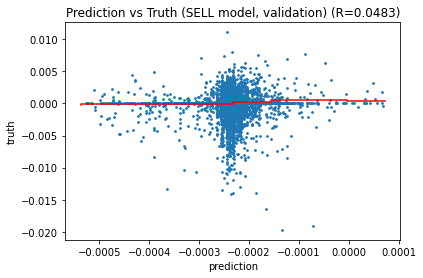

In [16]:
# バリデーション区間でのリターンの真値とリターンの予測値を散布図で比較する
display_true_vs_pred(df_validation['y_buy'], df_validation['y_pred_buy'], 'Prediction vs Truth (BUY model, validation)')
display_true_vs_pred(df_validation['y_sell'], df_validation['y_pred_sell'], 'Prediction vs Truth (SELL model, validation)')

<AxesSubplot:title={'center':'Feature importance (SELL model)'}, xlabel='Feature importance', ylabel='Features'>

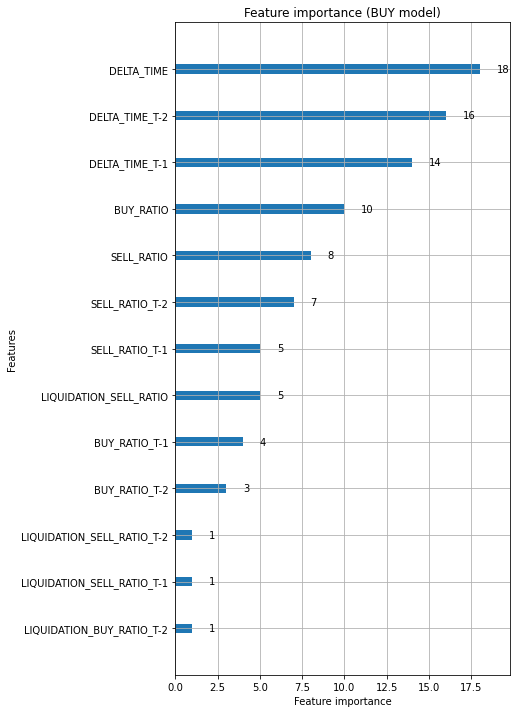

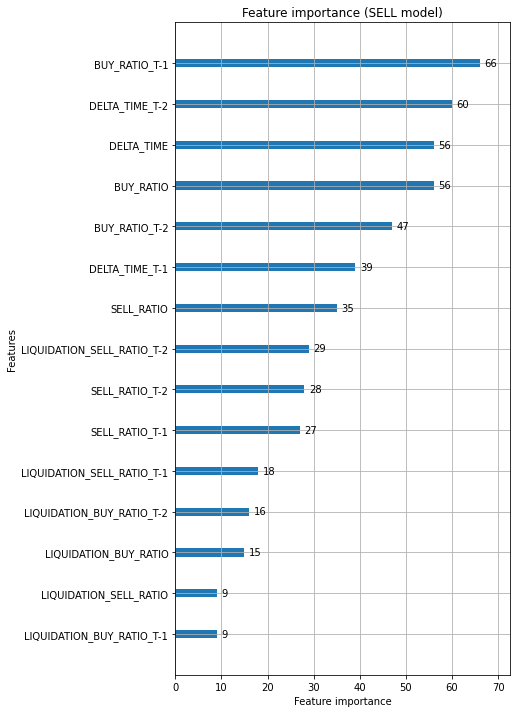

In [17]:
# 特徴量の重要度を表示する
lgb.plot_importance(model_buy, title='Feature importance (BUY model)', figsize=(6, 12))
lgb.plot_importance(model_sell, title='Feature importance (SELL model)', figsize=(6, 12))

In [18]:
@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

/tmp/ipykernel_1905584/917263284.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BUY_RATIO_LOGDIFF_T-2'] = df['BUY_RATIO_LOGDIFF'].shift(2)
/tmp/ipykernel_1905584/917263284.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['SELL_RATIO_LOGDIFF_T-2'] = df['SELL_RATIO_LOGDIFF'].shift(2)
/tmp/ipykernel_1905584/917263284.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

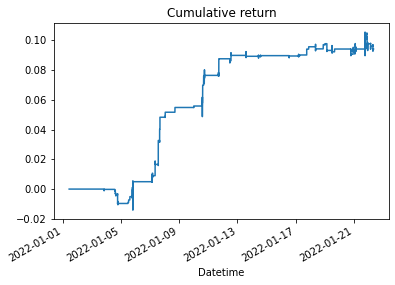

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


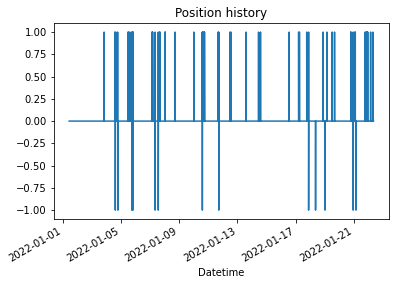

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


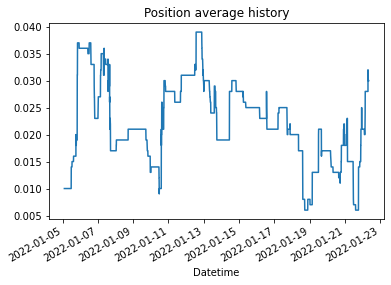

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


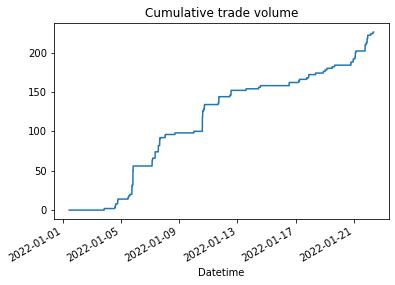

t test
t value 2.519731386603919
p value 0.011764551575578227
p平均法 n = 5
p平均 0.4959447988164385
エラー率 0.7813317554668883


In [19]:
df_validation = pd.read_pickle('df_validation_ohlcv.pkl')
df_validation = calc_buysell(df_validation, pips = 1, atr_mux = atr_mux, atr_range = atr_range)
df_validation = calc_features(df_validation)
df_validation.loc[:, 'y_pred_buy'] = model_buy.predict(df_validation[features], num_iteration=model_buy.best_iteration)
df_validation.loc[:, 'y_pred_sell'] = model_sell.predict(df_validation[features], num_iteration=model_sell.best_iteration)

# バックテストで累積リターンと、ポジションを計算
df_validation['cum_ret'], df_validation['poss'] = backtest(
    cl=df_validation['Close'].values,
    buy_entry=df_validation['y_pred_buy'].values > 0,
    sell_entry=df_validation['y_pred_sell'].values > 0,
    buy_cost=df_validation['buy_cost'].values,
    sell_cost=df_validation['sell_cost'].values,
)

df_validation['cum_ret'].plot()
plt.title('Cumulative return')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df_validation['poss'].plot()
plt.title('Position history')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df_validation['poss'].rolling(1000).mean().plot()
plt.title('Position average history')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df_validation['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('Cumulative trade volume')
plt.show()

print('t test')
x = df_validation['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t value {}'.format(t))
print('p value {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df_validation['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

In [20]:
# バリデーション区間のドルバーの間隔について確認する
df_validation['DELTA_TIME'].describe()

count    7685.000000
mean      235.053071
std       245.614211
min         0.000000
25%        57.121000
50%       150.184000
75%       335.747000
max      2036.219000
Name: DELTA_TIME, dtype: float64